# Zillow Project - Predict Zestimate (logerror)

#### Goals:

1. Build a model to predict Zestimate (logerror)

2. I.D. what is driving the Zestimate

### Planning
Pipeline:
    
   1. ***Acquire*** - Create a sql query that will connect to zillow database. The query will pull data for properties that were sold in 2017, and their Zestimate. The dataframe acquired will give us features to evaluate how they affect the Zestimate target variable.
   2. ***Prep*** - Clean NaN values with imputing, and setting qualifying properties for columns and rows with proportions that must be filled. Rename columns to be short and easy to use names. Put features in to proper numeric and catagorical data types. Scale features to be used in explore
   3. ***Explore*** - Split prepped dataframe into train and test. Use clustering to find out how different properties, are distributed in the zestimate target. Use statistical tests to find how properties in the dataset are simalar or different. Create new features from dataset, that can give more insight into what influences the value of properites. Find top features that drive Zestimate to create a predictive model
   4. ***Model*** - Create predictive models with features evaluated in explore phase. Evaluate models to find closest predictive error to the actual Zestimate.

### Acquire

***sql query***: We created a query that uses the zillow dataset to select properties that were sold in 2017. If a house was sold multiple times in 2017 we only selected the most recent transaction date. The properties_2017 table contained all of the features of homes such as sqft, value, location, etc.

In this notebook we will read the dataframe produced by the query from a csv file. If needed included in this project repository is the [acquire file](https://github.com/callapena/zillow_cluster/blob/master/acquire.py) used to query from mysql (will need personal env.py file). Our acquire function will query the sql database and create a csv file of the query unless that csv file already exists, in which case it will simply pull the data from there.

In [1]:
# make imports for modules and packages to be used throughout the notebook.
import warnings
warnings.filterwarnings("ignore")

import acquire
import prepare
from split_scale import scale
from model import cluster_exam
from model import validation
from model import many_models
from model import evaluate_dict, best_model, best_test

import pandas as pd 
import numpy as np 

import seaborn as sns
sns.set_style('whitegrid')
sns.set_palette('husl')
import matplotlib.pyplot as plt 
from matplotlib import cm

from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

from scipy import stats

from mpl_toolkits.mplot3d import Axes3D


In [2]:
#import ipympl

In [3]:
# get dataframe from aquire.py module.
zillow = acquire.get_zillow()

### Prepare.py

In [4]:
# Initial view of dataframe using.info()
# rows: 52292
# columns: 62
zillow.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52292 entries, 0 to 52291
Data columns (total 62 columns):
Unnamed: 0                      52292 non-null int64
logerror                        52292 non-null float64
transactiondate                 52292 non-null object
id                              52292 non-null int64
parcelid                        52292 non-null int64
airconditioningtypeid           13610 non-null float64
architecturalstyletypeid        70 non-null float64
basementsqft                    47 non-null float64
bathroomcnt                     52292 non-null float64
bedroomcnt                      52292 non-null float64
buildingclasstypeid             0 non-null float64
buildingqualitytypeid           33632 non-null float64
calculatedbathnbr               52158 non-null float64
decktypeid                      388 non-null float64
finishedfloor1squarefeet        4368 non-null float64
calculatedfinishedsquarefeet    52211 non-null float64
finishedsquarefeet12           

***Prepare steps:***
1. Drop columns that have less than 10% non-null value, then rows that have less than 60% non-null values
2. Drop columns that appear to provide little information:
    - `assessmentyear`
    - `unitcnt` (all 1)
    - `finishedsquarefeet12`
    - `propertylandusetypeid`
    - `rawcensustractandblock`
    - `censustractandblock`
    - `threequarterbathnbr`
    - `pooltypeid7`
    - `roomcnt`
    - `buildingqualitytypeid`
    - `calculatedbathnbr`
3. Drop rows that have 0/null beds, baths, or sqft
4. Dictionary for shorter names
5. Drop outliers - 
    - sqft > 10,000 
    - lotsizesqft > 3,000
    - structurevalue > 1,000,000 or < 0
    - beds > 7
    - bath > 7
    - garage > 5
    - stories > 3
6. Columns that will be dropped based off of non-null and information gain value:
    - `airconditioningtypeid` - Few values in column, 75% missing.
    - `fullbathcnt` - Already have similar information in bathcnt that has no non-null values. Will drop because of redundancy.
    - `heatingorsystemtypeid` - This will not be a major driver of logerror. Might be added in a later follow up and impute values.
    - `propertylandusecodetypeid` - All of these values are single family residential `id: 261`
    - `propertycountylandusecode` - Zoning at the county level. Little information gainded from this column.
    - `propertyzoningdesc` -Description of the allowed land use(zoning) for that property. Not sure what information is gained from this feature to drive zestimate error.
    - `regionidcounty` - Three county values, and same value counts as fips. Will drop because of redundancy.
    - `regionidneighborood` - Don't know where these neighborhoods are. Might use in later research if able to plot applicable neighborhoods.
    - `regionidzip` - Similar to neighborhood. Not sure where these zips correspond to.
    - `number of stories` - Few values in column, 72% missing.
7. Imputations - There was a roughly linear correlation between landvalue and lotsize.
8. Nulls represent 'no' or 0 - fireplace, pool

In [5]:
# Run prep_zillow from prepare module.
# prepped data frame info
# rows: 48944
# columns: 18
zillow = prepare.prep_zillow(zillow)
zillow.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48879 entries, 0 to 52290
Data columns (total 21 columns):
Unnamed: 0          48879 non-null int64
logerror            48879 non-null float64
date                48879 non-null object
baths               48879 non-null float64
beds                48879 non-null float64
sqft                48879 non-null float64
fips                48879 non-null float64
fireplace           48879 non-null int64
lat                 48879 non-null float64
long                48879 non-null float64
lotsqft             48879 non-null float64
pool                48879 non-null float64
city                48879 non-null float64
strucvalue          48879 non-null float64
value               48879 non-null float64
landvalue           48879 non-null float64
tax                 48879 non-null float64
age                 48879 non-null float64
strucvaluebysqft    48879 non-null float64
landvaluebysqft     48879 non-null float64
beds_and_baths      48879 non-null f

***Data dictionary:***

- ***logerror*** - logerror value of Zillow property value estimation ("zestimate"). This value was given in the data, and not aware of how zillow got these log values (i.e. base value used and transformations).
- ***date*** - transaction date the property was sold.
- ***baths*** - number of baths on the property including factional baths.
- ***beds*** - number of beds on the property.
- ***sqft*** - total finished living area of the home.
- ***fips*** -  Federal Information Processing Standard code -  see [wikipedia page - Fips county code](https://en.wikipedia.org/wiki/FIPS_county_code) for more details
- ***fireplace*** - Is there a fireplace in this property.
- ***lat*** - latitude of the middle of the parcel multiplied by 10e6.
- ***long*** - longitude of the middle of the parcel multiplied by 10e6.
- ***lotsqft*** - Area of the lot in square feet.
- ***pool*** - Is there apool in this property.
- ***city*** - In which city is the property located.
- ***strucvalue*** - The assessed value of the built structure on the parcel.
- ***value*** - The total tax assesed value of the property.
- ***landvalue*** - the assvalue of the land area of the property.
- ***tax*** - The total property tax for the assessment year.
- ***age*** - age of the house from 2017.

### Explore

Explore distributions of variables in the dataset, and how they drive target logerror variable.

***Encode Fips***

In [6]:
# Look at the value counts for fips
zillow.fips.value_counts()

6037.0    31410
6059.0    13406
6111.0     4063
Name: fips, dtype: int64

From research into federal fips codes we found the following coding for each value.
- 6037 - La County
- 6059 - Orange County
- 6111 - Ventura County

In [7]:
# Encode Fips
zillow['la'] = (zillow['fips'] == 6037).astype(int)
zillow['orange'] = (zillow['fips'] == 6059).astype(int)
zillow['ventura'] = (zillow['fips'] == 6111).astype(int)

zillow[['la', 'orange','ventura']].head()

,la,orange,ventura
0,0,1,0
1,0,0,1
2,0,1,0
3,1,0,0
5,1,0,0


***Train, Test, Split***

Create train & test data frames with 70% of data in train, and 30% in test. Separate X and y train dataframe where X_train will be our features, and y_train will logerror, the target.

In [8]:
train, test = train_test_split(zillow, test_size=.30, random_state=123)
# X1_train = train[['sqft', 'lotsqft', 'tax', 'age']]
# y1_train = train['logerror']
# test1 = test[['sqft', 'lotsqft', 'tax', 'age', 'logerror']]

In [9]:
# # Create train & test
# train, test = train_test_split(zillow, test_size=.30, random_state=123)

# # SCALE
# minmax = ['lat', 'long', 'age', 'logerror','sqft','lotsqft', 'tax']
# minmax_scaler, train_scaled, test_scaled = scale(train[minmax], test[minmax], minmax, scaler='minmax')

In [10]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,34215.0,2.602940e+04,15123.641878,0.000000e+00,1.295200e+04,2.594000e+04,3.914050e+04,5.228900e+04
logerror,34215.0,1.781410e-02,0.167405,-2.387800e+00,-2.417952e-02,6.836701e-03,3.920272e-02,3.175688e+00
baths,34215.0,2.225121e+00,0.897592,1.000000e+00,2.000000e+00,2.000000e+00,3.000000e+00,7.000000e+00
beds,34215.0,3.268479e+00,0.889521,1.000000e+00,3.000000e+00,3.000000e+00,4.000000e+00,7.000000e+00
sqft,34215.0,1.828855e+03,807.075844,1.520000e+02,1.256000e+03,1.626000e+03,2.210000e+03,8.013000e+03
fips,34215.0,6.049120e+03,20.837723,6.037000e+03,6.037000e+03,6.037000e+03,6.059000e+03,6.111000e+03
fireplace,34215.0,1.393541e-01,0.346321,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
lat,34215.0,3.401469e+07,269665.177057,3.334062e+07,3.382378e+07,3.401114e+07,3.418209e+07,3.472924e+07
long,34215.0,-1.181883e+08,352111.035199,-1.194484e+08,-1.183897e+08,-1.181464e+08,-1.179276e+08,-1.175724e+08
lotsqft,34215.0,7.607906e+03,4002.856242,4.800000e+02,5.503000e+03,6.745000e+03,8.318500e+03,3.000000e+04


In [11]:
# Create correlation table to look at variables as they relate to logerror.
train.corr()[['logerror']].sort_values(by=['logerror'], ascending = False)

,logerror
logerror,1.000000
beds_and_baths,0.032872
sqft,0.032616
beds,0.030930
baths,0.028335
long,0.027851
orange,0.026361
tax,0.014849
lotsqft,0.011507
city,0.009333


From the correlation column that relates to logerror, we want to explore columns that have greater correlation with logerror we will explore columns that have an absolute value correlation of .01 or higher. We believe that these will have the greatest influence on logerror

In [12]:
log_corr = train.corr().logerror[abs(train.corr().logerror) >= 0.01].index.values
log_corr

array(['logerror', 'baths', 'beds', 'sqft', 'lat', 'long', 'lotsqft',
       'pool', 'value', 'landvalue', 'tax', 'age', 'strucvaluebysqft',
       'landvaluebysqft', 'beds_and_baths', 'la', 'orange'], dtype=object)

In [13]:
# bed & baths are related to each other so we will drop those when looking at correlation
# Create a new datframe that takes the log_corr list, and drops beds, and baths
log_corr = train[log_corr].drop(columns=['beds','baths'])
log_corr.head()

,logerror,sqft,lat,long,lotsqft,pool,value,landvalue,tax,age,strucvaluebysqft,landvaluebysqft,beds_and_baths,la,orange
24301,0.913597,892.0,33340851.0,-118325581.0,1261.0,0.0,70612.0,45538.0,0.033685,97.0,28.109865,36.112609,4.0,1,0
23423,0.045102,2224.0,33778771.0,-118195717.0,3953.0,0.0,415000.0,271500.0,0.012073,112.0,64.523381,68.682014,5.0,1,0
33452,2.157266,1048.0,34056410.0,-118044624.0,19935.0,1.0,473000.0,331000.0,0.013574,80.0,135.496183,16.603963,3.0,1,0
42553,0.014159,1268.0,34213609.0,-119202265.0,6100.0,0.0,424000.0,276000.0,0.011727,47.0,116.719243,45.245902,5.0,0,0
29928,0.105112,1404.0,34264920.0,-118480978.0,9600.0,0.0,395287.0,218448.0,0.012352,69.0,125.953704,22.755000,5.0,1,0


In [14]:
log_corr.corr()

,logerror,sqft,lat,long,lotsqft,pool,value,landvalue,tax,age,strucvaluebysqft,landvaluebysqft,beds_and_baths,la,orange
logerror,1.000000,0.032616,-0.020930,0.027851,0.011507,-0.015526,-0.020094,-0.025313,0.014849,-0.012158,-0.038644,-0.016726,0.032872,-0.019826,0.026361
sqft,0.032616,1.000000,-0.060577,0.035149,0.414626,0.321075,0.544005,0.374014,-0.129279,-0.478186,0.267182,0.133422,0.812842,-0.191474,0.167371
lat,-0.020930,-0.060577,1.000000,-0.552466,0.222138,0.010886,-0.186125,-0.220955,0.186175,-0.022631,0.033867,-0.286431,-0.010150,0.484361,-0.676005
long,0.027851,0.035149,-0.552466,1.000000,-0.101942,0.002303,0.002066,0.016740,0.011512,-0.122517,-0.119826,0.077694,0.025241,-0.189908,0.615412
lotsqft,0.011507,0.414626,0.222138,-0.101942,1.000000,0.319087,0.201593,0.136921,-0.029302,-0.066534,0.078794,-0.255112,0.305322,0.081690,-0.130587
pool,-0.015526,0.321075,0.010886,0.002303,0.319087,1.000000,0.199376,0.144231,-0.082307,-0.091304,0.123367,-0.029066,0.279240,-0.038198,0.046892
value,-0.020094,0.544005,-0.186125,0.002066,0.201593,0.199376,1.000000,0.961122,-0.233220,-0.198232,0.625142,0.674979,0.402414,-0.118031,0.124567
landvalue,-0.025313,0.374014,-0.220955,0.016740,0.136921,0.144231,0.961122,1.000000,-0.222552,-0.063846,0.482515,0.730717,0.257851,-0.098234,0.129220
tax,0.014849,-0.129279,0.186175,0.011512,-0.029302,-0.082307,-0.233220,-0.222552,1.000000,0.048590,-0.209082,-0.187820,-0.105260,0.187469,-0.146207
age,-0.012158,-0.478186,-0.022631,-0.122517,-0.066534,-0.091304,-0.198232,-0.063846,0.048590,1.000000,-0.258396,-0.077630,-0.506004,0.390523,-0.311493


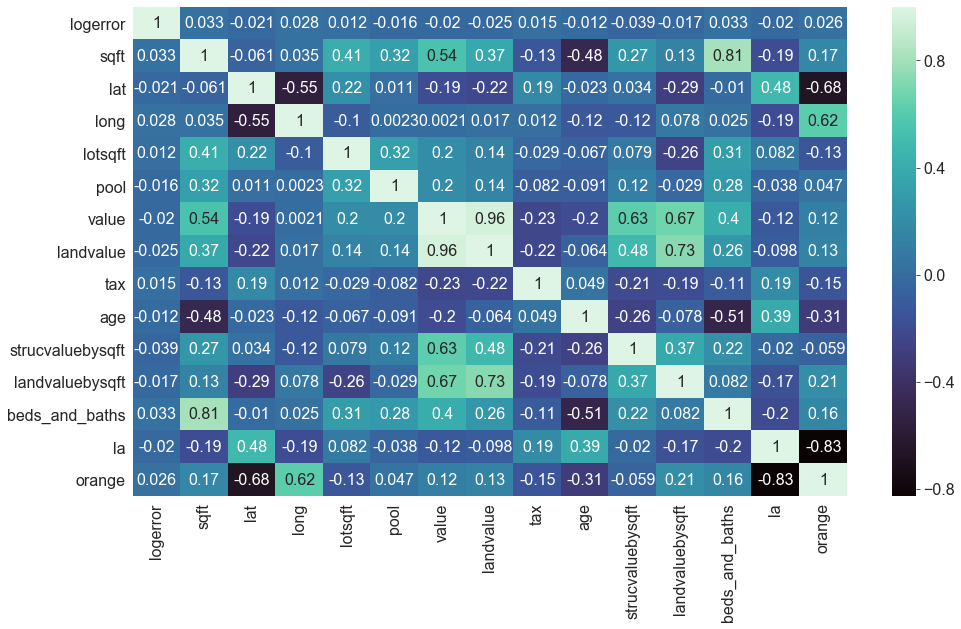

In [15]:
plt.rc('font', size=16)
plt.figure(figsize = (16,9))
g = sns.heatmap(log_corr.corr(), annot=True, cmap = "mako")

In [16]:
#sns.pairplot(log_corr)

<img src="pics/pair_plot.png">

***Scaling***

From the pairplot it looks like the features that we have chosen from log_corr have a similar distribution when plotted against logerror.

Create new dataframes X(features), y(target) dataframes containing the features we found were correlated with logerror > .01

In [17]:
features = log_corr.drop(columns=['logerror']).columns.values
target = ['logerror']

# SCALE
uniform = ['beds_and_baths', 'sqft', 'lotsqft', 'strucvaluebysqft', 'landvaluebysqft', 'tax']
minmax = ['lat', 'long', 'age']
uniform_scaler, train, test = scale(train, test, uniform, scaler='uniform')
minmax_scaler, train, test = scale(train, test, minmax, scaler='minmax')

X_train = train[features]
X_test = test[features]
y_train = train[target]
y_test = test[target]

### Exploring: Clustering on logerror

In [18]:
# Look at the value_counts of logerror
train.logerror.value_counts(bins = 4).sort_index()

(-2.3939999999999997, -0.997]       32
(-0.997, 0.394]                  33624
(0.394, 1.785]                     501
(1.785, 3.176]                      58
Name: logerror, dtype: int64

Text(0.5, 1.0, 'Distribution of Log Error')

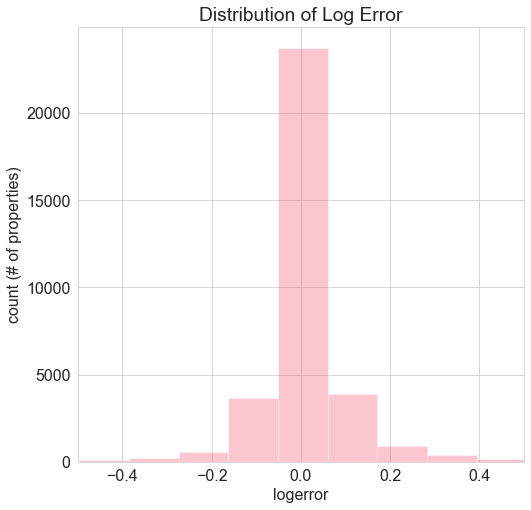

In [19]:
# Plot the distribution of logerror from the train dataset
plt.figure(figsize=(8,8))
sns.distplot(train.logerror, kde=False)
plt.xlim(-.5,.5)
plt.ylabel('count (# of properties)')
plt.title('Distribution of Log Error')

In [20]:
cluster_exam(12, train, target)

,k,sse,change_in_sse
0,1,958.829296,NaN
1,2,572.397507,-386.431789
2,3,398.570651,-173.826856
3,4,271.484877,-127.085774
4,5,203.758222,-67.726655
5,6,147.599364,-56.158858
6,7,110.213390,-37.385974
7,8,84.298660,-25.914730
8,9,66.344779,-17.953881
9,10,53.607863,-12.736916


In [21]:
kmeans = KMeans(n_clusters = 8, random_state = 123)
kmeans.fit(train[['logerror']])

train['log_cluster'] = kmeans.predict(train[['logerror']])
train.log_cluster = 'cluster_' + train.log_cluster.astype('str')
train.log_cluster.value_counts()

cluster_1    22108
cluster_0     6832
cluster_6     3421
cluster_4     1259
cluster_2      280
cluster_5      226
cluster_3       69
cluster_7       20
Name: log_cluster, dtype: int64

***Insight*** When using KMeans to cluster properties by logerror we see that %66 of the properties in train are put into one cluster. When there is a very large cluster that contains most of the data we can say that the logerrors between the properties are very similar. This will make it difficult to create sub category clusters. We will classify significant clusters using statistical tests.

***TTest - logerror clusters***

In [22]:
# Look at the mean logerror of each cluster
pd.DataFrame(kmeans.cluster_centers_, columns=zillow[['logerror']].columns)\
    .reset_index()\
    .rename({'index': 'cluster'}, axis=1)\
    .set_index('cluster')

,logerror
cluster,
0,0.083584
1,-0.003067
2,-0.545643
3,2.182844
4,0.313222
5,0.844250
6,-0.125408
7,-2.083002


In [23]:
# The mean logerror of the population
train.logerror.mean()

0.017814098096996096

In [24]:
# cluster_1 is the largest cluster of our train population. We will compare this with the mean of properties not in cluster_1.
train[train.log_cluster == 'cluster_1'].logerror.mean()

-0.0031837800993108137

In [25]:
train[train.log_cluster != 'cluster_1'].logerror.mean()

0.05615729551699722

Both of the means are distinct. The mean logerror of  properties in cluster_1 is already very low near .003

We will use a 2 sample t-test to find if each cluster on logerror is significant.

In [26]:
significant_clusters = []
p_vals = []

for i in sorted(train.log_cluster.unique()):
    stat, pval = stats.ttest_ind(
        train[train.log_cluster == i].logerror,
        train[train.log_cluster != i].logerror)
    if pval < .05:
        significant_clusters = significant_clusters + [i]
        p_vals = p_vals + [pval]
pd.DataFrame({'significant_clusters': significant_clusters, 'p_vals': p_vals}).set_index('significant_clusters')


,p_vals
significant_clusters,
cluster_0,6.615244e-292
cluster_1,6.836291e-219
cluster_2,0.000000e+00
cluster_3,0.000000e+00
cluster_4,0.000000e+00
cluster_5,0.000000e+00
cluster_6,0.000000e+00
cluster_7,0.000000e+00


All clusters return as significant so we will not be able to eliminate any subgroups.

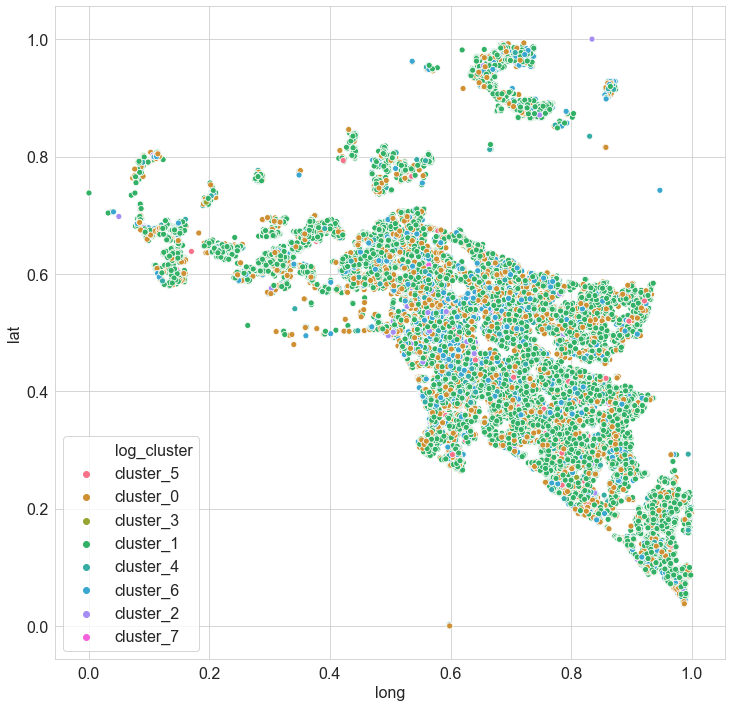

In [27]:
# Create a plot of lat & long with log_clusters representing colors
plt.figure(figsize = (12,12))
sns.scatterplot(x='long', y='lat', data=train, hue='log_cluster')

Text(0.5, 0.98, 'How is logerror distributed by location? (latitude & longitude)')

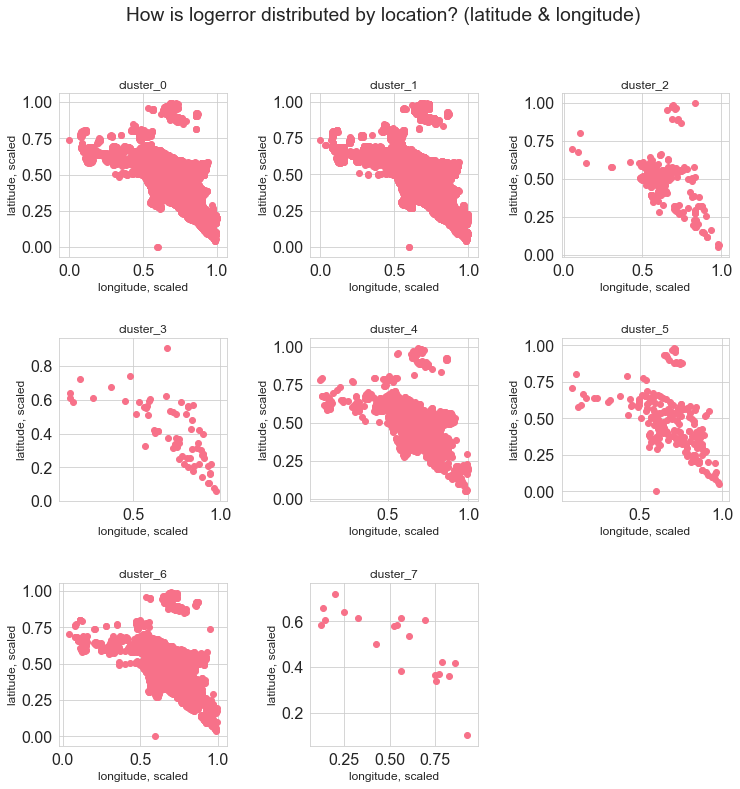

In [28]:
# Plot how each cluster is distributed in lat & long
plt.figure(figsize = (12,12))
for i, cluster in enumerate(sorted(train.log_cluster.unique())):
    plt.subplot(3, 3, i + 1)
    subset = train[train.log_cluster == cluster]
    plt.scatter(subset.long, subset.lat, label=cluster)
    
    plt.title(f'{cluster}', size=12)
    plt.xlabel('longitude, scaled', size=12)
    plt.ylabel('latitude, scaled', size=12)
    
#     plt.hlines(mpg.hwy.mean(), mpg.displ.min(), mpg.displ.max(), ls=':', color='red')
#     plt.vlines(mpg.displ.mean(), mpg.hwy.min(), mpg.hwy.max(), ls=':', color='red')

plt.subplots_adjust(wspace=.5, hspace = .5)
plt.suptitle('How is logerror distributed by location? (latitude & longitude)')

***Findings***
The logerror values spead accross all properties in the data set. There is no one area that has a specific set of logerrors to be idenditifed. From our t-test we found that all of our clusters were significant when compared to each other. Because all of these clusters were significant there are no clusters that we can combine together to make into subsets.

### Explore: Cluster on lat, long

Plot the distributions of latitude & longitude

Text(0.5, 1.0, 'Distribution by Latitude')

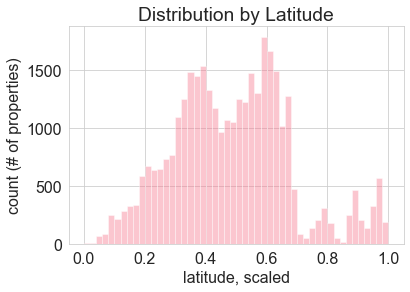

In [29]:
sns.distplot(train.lat, kde = False)
plt.ylabel('count (# of properties)')
plt.xlabel('latitude, scaled')
plt.title('Distribution by Latitude')

Text(0.5, 1.0, 'Distribution by Longitude')

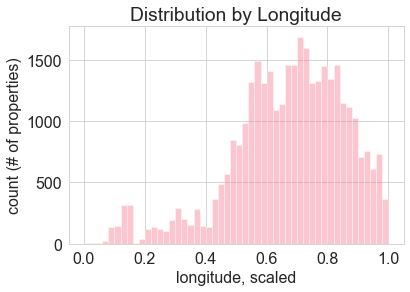

In [30]:
sns.distplot(train.long, kde = False)
plt.ylabel('count (# of properties)')
plt.xlabel('longitude, scaled')
plt.title('Distribution by Longitude')

In [31]:
# Look at sum of squared errors based on number of clusters (k)
cluster_exam(12, train, ['lat','long'])

,k,sse,change_in_sse
0,1,2495.630073,NaN
1,2,1166.397606,-1329.232467
2,3,845.331225,-321.066381
3,4,568.776389,-276.554837
4,5,415.850741,-152.925647
5,6,310.706122,-105.144620
6,7,243.397368,-67.308753
7,8,200.422817,-42.974551
8,9,178.386881,-22.035936
9,10,159.486103,-18.900778


In [32]:
estimators = [('3 Clusters', KMeans(n_clusters=3)),
              ('7 Clusters', KMeans(n_clusters=7)),
             ('10 Clusters', KMeans(n_clusters=10))]

<Figure size 432x288 with 0 Axes>

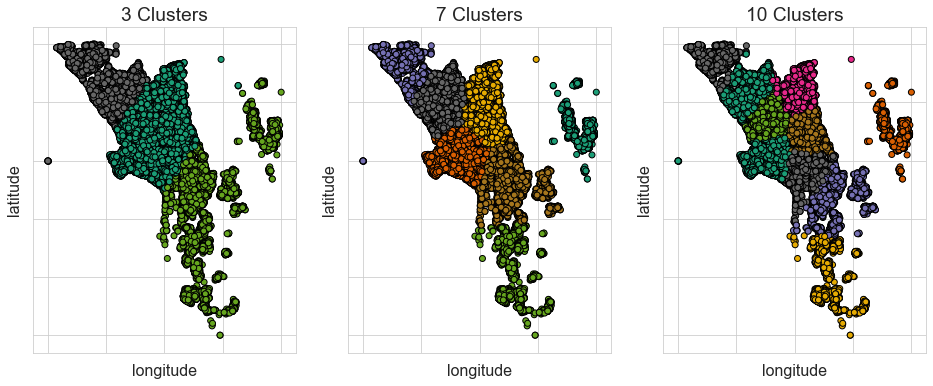

In [33]:
plt.set_cmap('Dark2')
fig, axs = plt.subplots(1, 3, figsize=(16, 6))

for ax, (title, kmeans) in zip(axs, estimators):
    # fit the kmeans object
    kmeans.fit(train[['lat','long']])

    labels = kmeans.labels_

    ax.scatter(train.lat, 
               train.long,
               c=labels.astype(np.float), edgecolor='k')
    ax.set(xticklabels=[], yticklabels=[])
    ax.set(xlabel='longitude', ylabel='latitude')
    ax.set(title=title)
    
    
    

at 7 clusters or 8 clusters there seems to be a plataue in difference of sse (elbow method). From our dataframe we will look at what clusters look like at k=7 and k=8.

In [34]:
# value counts of properties in each cluster when k=7
kmeans_7 = KMeans(n_clusters = 7)
kmeans_7.fit(train[['lat','long']])

train['lat_long_cluster'] = kmeans_7.predict(train[['lat', 'long']])
train.lat_long_cluster = 'cluster_' + train.lat_long_cluster.astype('str')
train.lat_long_cluster.value_counts()

cluster_0    7325
cluster_1    6736
cluster_5    6281
cluster_2    5482
cluster_4    3626
cluster_6    2600
cluster_3    2165
Name: lat_long_cluster, dtype: int64

In [35]:
# value counts of properties in each cluster when k=8
kmeans_8 = KMeans(n_clusters = 8)
kmeans_8.fit(train[['lat','long']])

train['lat_long_cluster_8'] = kmeans_8.predict(train[['lat', 'long']])
train.lat_long_cluster_8 = 'cluster_' + train.lat_long_cluster_8.astype('str')
train.lat_long_cluster_8.value_counts()

cluster_1    6307
cluster_5    5688
cluster_2    5677
cluster_7    4729
cluster_0    4452
cluster_6    3015
cluster_4    2182
cluster_3    2165
Name: lat_long_cluster_8, dtype: int64

In [36]:
# Centers of lat, long clusters where k =7
pd.DataFrame(kmeans_7.cluster_centers_, columns=train[['lat', 'long']].columns)\
    .reset_index()\
    .rename({'index': 'cluster'}, axis=1)\
    .set_index('cluster')

,lat,long
cluster,,
0,0.338908,0.799042
1,0.631144,0.523171
2,0.530597,0.775000
3,0.930400,0.702662
4,0.178408,0.925280
5,0.416741,0.615679
6,0.648187,0.236774


In [37]:
# Centers of lat, long clusters where k = 8
pd.DataFrame(kmeans_8.cluster_centers_, columns=train[['lat', 'long']].columns)\
    .reset_index()\
    .rename({'index': 'cluster'}, axis=1)\
    .set_index('cluster')

,lat,long
cluster,,
0,0.660396,0.475114
1,0.319175,0.819355
2,0.381549,0.645821
3,0.930400,0.702662
4,0.648245,0.212260
5,0.552949,0.602332
6,0.166307,0.938910
7,0.510152,0.802885


In [38]:
# Look at the average age of each cluster when k = 7
logerrors = []
age = []
clusters = []
for i in sorted(train.lat_long_cluster.unique()):
    logerrors = logerrors + [train[train.lat_long_cluster == i].logerror.mean()]
    age = age + [train[train.lat_long_cluster == i].age.mean()]
    clusters.append(i)

lat_long_logerror = pd.DataFrame({'clusters': clusters, 'logerror': logerrors, 'age': age})
lat_long_logerror

,clusters,logerror,age
0,cluster_0,0.021675,0.368707
1,cluster_1,0.014950,0.417407
2,cluster_2,0.023462,0.448350
3,cluster_3,0.012258,0.217622
4,cluster_4,0.028182,0.238853
5,cluster_5,0.009076,0.509825
6,cluster_6,0.013726,0.291154


In [39]:
# Look at the average age of each cluster when k = 8
logerrors = []
age = []
clusters = []
for i in sorted(train.lat_long_cluster_8.unique()):
    logerrors = logerrors + [train[train.lat_long_cluster_8 == i].logerror.mean()]
    age = age + [train[train.lat_long_cluster_8 == i].age.mean()]
    clusters.append(i)

lat_long_cluster_8 = pd.DataFrame({'clusters': clusters, 'logerror': logerrors, 'age': age})
lat_long_cluster_8

,clusters,logerror,age
0,cluster_0,0.020390,0.361197
1,cluster_1,0.024623,0.341892
2,cluster_2,0.015579,0.477444
3,cluster_3,0.012258,0.217622
4,cluster_4,0.012503,0.294458
5,cluster_5,0.002133,0.532284
6,cluster_6,0.026021,0.231021
7,cluster_7,0.027613,0.413215


In [40]:
avg_age = train.groupby('lat_long_cluster').age.mean().sort_values()

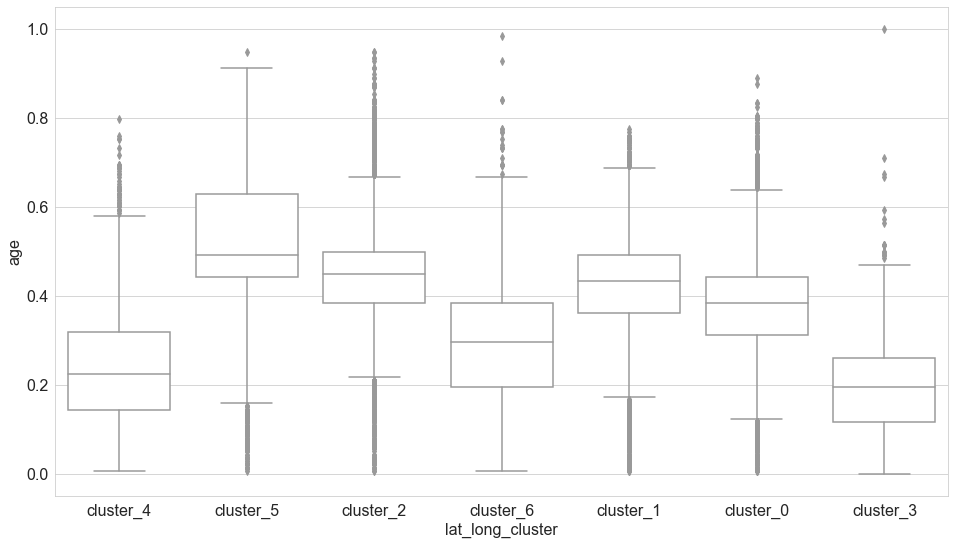

In [41]:
plt.rc('font', size=16)
plt.figure(figsize = (16,9))
sns.boxplot(x = 'lat_long_cluster', y = 'age', data=train, color = 'white')
                                                                   

In [42]:
centers = pd.DataFrame(kmeans_7.cluster_centers_, 
             train.groupby('lat_long_cluster').age.mean(), 
             columns = ['lat', 'long']).reset_index()
                                                                                             
centers

,age,lat,long
0,0.368707,0.338908,0.799042
1,0.417407,0.631144,0.523171
2,0.448350,0.530597,0.775000
3,0.217622,0.930400,0.702662
4,0.238853,0.178408,0.925280
5,0.509825,0.416741,0.615679
6,0.291154,0.648187,0.236774


In [43]:
centers = pd.DataFrame({'lat_centers': kmeans_7.cluster_centers_[:,0],
                'long_centers': kmeans_7.cluster_centers_[:,1],
            'age_mean': train.groupby('lat_long_cluster').age.mean(),
             'logerror': train.groupby('lat_long_cluster').logerror.mean(),
             'tax': train.groupby('lat_long_cluster').tax.mean(),
             'sqft': train.groupby('lat_long_cluster').sqft.mean(),
             'lotsqft': train.groupby('lat_long_cluster').lotsqft.mean()}).reset_index()
centers

,lat_long_cluster,lat_centers,long_centers,age_mean,logerror,tax,sqft,lotsqft
0,cluster_0,0.338908,0.799042,0.368707,0.021675,0.447848,0.494860,0.441075
1,cluster_1,0.631144,0.523171,0.417407,0.014950,0.508246,0.534901,0.619025
2,cluster_2,0.530597,0.775000,0.448350,0.023462,0.602627,0.430622,0.586160
3,cluster_3,0.930400,0.702662,0.217622,0.012258,0.890776,0.530582,0.625530
4,cluster_4,0.178408,0.925280,0.238853,0.028182,0.222272,0.677938,0.377550
5,cluster_5,0.416741,0.615679,0.509825,0.009076,0.591409,0.383690,0.362069
6,cluster_6,0.648187,0.236774,0.291154,0.013726,0.250272,0.577554,0.575438


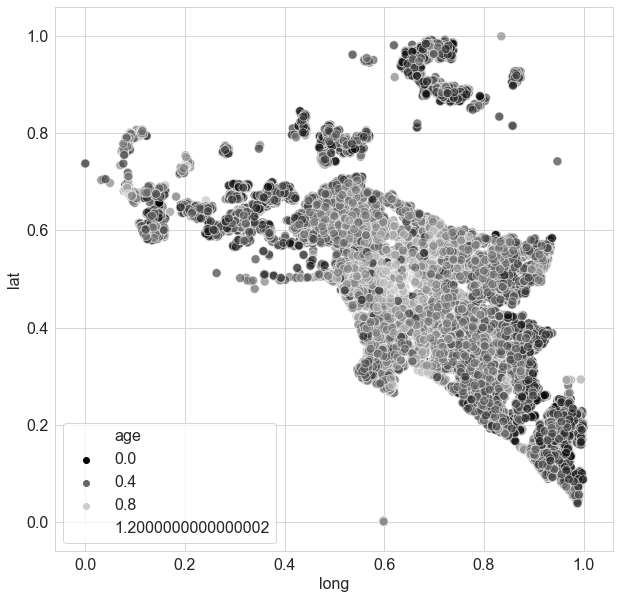

In [44]:
plt.figure(figsize=(10,10))
sns.scatterplot(x='long', y='lat', data=train, hue='age', s=80, alpha = .6, palette = 'gray')

<Figure size 432x288 with 0 Axes>

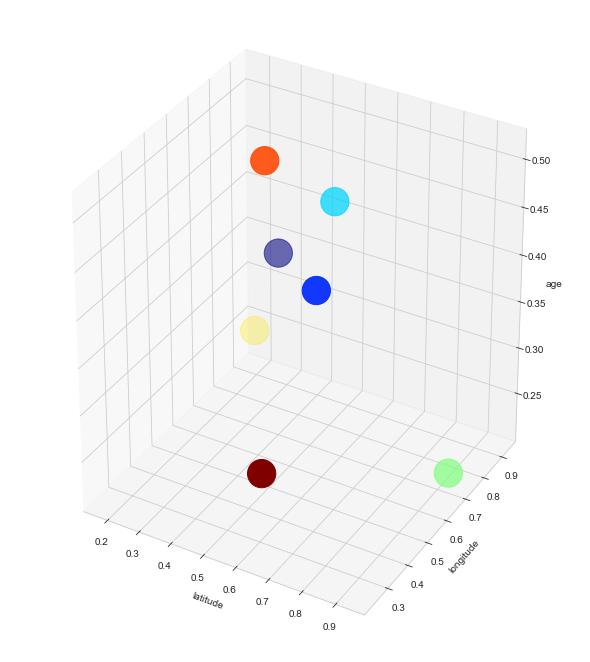

In [45]:
%matplotlib widget
%matplotlib notebook
%matplotlib inline

plt.set_cmap('jet')
fig = plt.figure(figsize=(8, 9))
ax = Axes3D(fig)



ax.scatter(centers.lat_centers, centers.long_centers, centers.age_mean, c= list(centers.index), s=800)
ax.set(xlabel='latitude', ylabel='longitude', zlabel='age')
plt.show()
#ax.scatter(train.long, train.lat, train.age, c=kmeans.labels_)


In [46]:
significant_clusters = []
p_vals = []

for i in train.lat_long_cluster.unique():
    stat, pval = stats.ttest_ind(
        train[train.lat_long_cluster == i].age,
        train[train.lat_long_cluster != i].age)
    if pval < .05:
        significant_clusters = significant_clusters + [i]
        p_vals = p_vals + [pval]
pd.DataFrame({'significant_clusters': significant_clusters, 'p_vals': p_vals}).set_index('significant_clusters')

,p_vals
significant_clusters,
cluster_4,0.000000e+00
cluster_5,0.000000e+00
cluster_2,3.686974e-198
cluster_6,4.747716e-217
cluster_1,8.963801e-62
cluster_0,3.633648e-29
cluster_3,0.000000e+00


In [47]:
centers = pd.DataFrame({'lat_centers': kmeans_8.cluster_centers_[:,0],
                'long_centers': kmeans_8.cluster_centers_[:,1],
            'age_mean': train.groupby('lat_long_cluster_8').age.mean(),
             'logerror': train.groupby('lat_long_cluster_8').logerror.mean(),
             'tax': train.groupby('lat_long_cluster_8').tax.mean(),
             'sqft': train.groupby('lat_long_cluster_8').sqft.mean(),
             'lotsqft': train.groupby('lat_long_cluster_8').lotsqft.mean()}).reset_index()
centers

,lat_long_cluster_8,lat_centers,long_centers,age_mean,logerror,tax,sqft,lotsqft
0,cluster_0,0.660396,0.475114,0.361197,0.020390,0.563511,0.539815,0.641559
1,cluster_1,0.319175,0.819355,0.341892,0.024623,0.404389,0.537579,0.453146
2,cluster_2,0.381549,0.645821,0.477444,0.015579,0.601705,0.357977,0.341970
3,cluster_3,0.930400,0.702662,0.217622,0.012258,0.890776,0.530582,0.625530
4,cluster_4,0.648245,0.212260,0.294458,0.012503,0.223104,0.569735,0.563846
5,cluster_5,0.552949,0.602332,0.532284,0.002133,0.464157,0.483186,0.506854
6,cluster_6,0.166307,0.938910,0.231021,0.026021,0.215908,0.685649,0.392528
7,cluster_7,0.510152,0.802885,0.413215,0.027613,0.618718,0.438497,0.592281


In [48]:
significant_clusters = []
p_vals = []

for i in train.lat_long_cluster.unique():
    stat, pval = stats.ttest_ind(
        train[train.lat_long_cluster_8 == i].age,
        train[train.lat_long_cluster_8 != i].age)
    if pval < .05:
        significant_clusters = significant_clusters + [i]
        p_vals = p_vals + [pval]
pd.DataFrame({'significant_clusters': significant_clusters, 'p_vals': p_vals}).set_index('significant_clusters')

,p_vals
significant_clusters,
cluster_4,1.299619e-167
cluster_5,0.000000e+00
cluster_2,0.000000e+00
cluster_6,0.000000e+00
cluster_1,1.844172e-134
cluster_0,4.966001e-31
cluster_3,0.000000e+00


### Cluster lat, long, tax_rate

Text(0.5, 1.0, 'distribution of tax_rate')

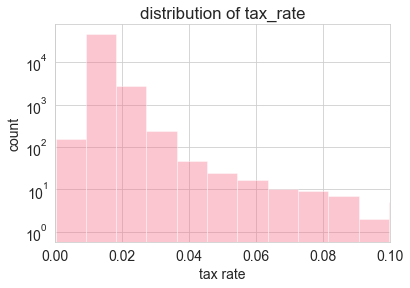

In [49]:
plt.rc('font', size = 14)
sns.distplot(zillow.tax, kde = False)
plt.xlim(0,0.1)
plt.yscale('log')
plt.xlabel('tax rate')
plt.ylabel('count')
plt.title('distribution of tax_rate')

In [50]:
cluster_exam(13,train,['lat','long','tax'])

,k,sse,change_in_sse
0,1,5347.068156,NaN
1,2,3117.023508,-2230.044647
2,3,2163.167095,-953.856413
3,4,1596.929146,-566.237949
4,5,1278.503373,-318.425773
5,6,1065.701901,-212.801472
6,7,919.660628,-146.041273
7,8,803.515332,-116.145296
8,9,721.297641,-82.217691
9,10,646.044764,-75.252877


In [51]:
estimators = [('3 Clusters', KMeans(n_clusters=3)),
              ('9 Clusters', KMeans(n_clusters=7))]

<Figure size 432x288 with 0 Axes>

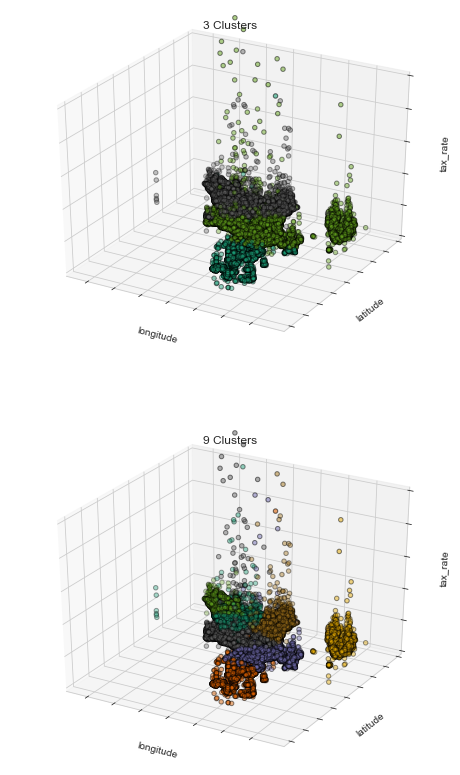

In [52]:
%matplotlib widget
%matplotlib inline
plt.set_cmap('Dark2')
fig, axs = plt.subplots(2, 1, figsize=(8, 14), subplot_kw={'projection': '3d'})

for ax, (title, kmeans) in zip(axs, estimators):
    # fit the kmeans object
    kmeans.fit(zillow[['lat','long','tax']])

    labels = kmeans.labels_

    ax.scatter(zillow.lat, 
               zillow.long,
               zillow.tax,
               c=labels.astype(np.float), edgecolor='k')
    ax.set(xticklabels=[], yticklabels=[], zticklabels=[])
    ax.set(xlabel='longitude', ylabel='latitude', zlabel='tax_rate')
    ax.set(zlim = (0,.1))
    ax.set(title=title)


### Explore: Neighborhood & Amenities



In [268]:
# reset dataframe in case we accidentally made any changes
zillow = acquire.get_zillow()
zillow = prepare.prep_zillow(zillow)
zillow['la'] = (zillow['fips'] == 6037).astype(int)
zillow['orange'] = (zillow['fips'] == 6059).astype(int)
zillow['ventura'] = (zillow['fips'] == 6111).astype(int)
train, test = train_test_split(zillow, test_size=.30, random_state=123)

# Save some unscaled data for later modeling
X1_train = train[['sqft', 'lotsqft', 'tax', 'age']]
y1_train = train['logerror']
test1 = test[['sqft', 'lotsqft', 'tax', 'age', 'logerror']]

features = ['beds_and_baths', 'sqft', 'fireplace', 'lat', 'long', 'lotsqft', 'pool',
            'tax', 'age', 'strucvaluebysqft', 'landvaluebysqft', 'la', 'orange', 'ventura']
target = 'logerror'

# SCALE
uniform = ['beds_and_baths', 'sqft', 'lotsqft', 'strucvaluebysqft', 'landvaluebysqft', 'tax']
minmax = ['lat', 'long', 'age']
uniform_scaler, train, test = scale(train, test, uniform, scaler='uniform')
minmax_scaler, train, test = scale(train, test, minmax, scaler='minmax')

X_train = train[features]
X_test = test[features]
y_train = train[target]
y_test = test[target]

In [269]:
# Create list of features that relate to neighborhood
neighborhood = ['lat', 'long', 'strucvaluebysqft', 'landvaluebysqft']

In [270]:
# Create list of features that relate to amenities of a property
amenities = ['beds_and_baths', 'sqft', 'lotsqft', 'age']


In [217]:
# Look at sse of K-clusters for neighborhood list
cluster_exam(13, X_train, neighborhood)


,k,sse,change_in_sse
0,1,8198.400403,NaN
1,2,5131.399304,-3067.001098
2,3,3950.756499,-1180.642805
3,4,3207.431053,-743.325446
4,5,2780.567171,-426.863881
5,6,2397.841471,-382.725700
6,7,2141.424042,-256.417429
7,8,1953.191896,-188.232146
8,9,1794.393075,-158.798821
9,10,1660.601386,-133.791690


Looks like where k = 8 the change in sse plateaus

In [218]:
# Look at sse of K-clusters for neighborhood list
cluster_exam(13, X_train, amenities)


,k,sse,change_in_sse
0,1,9391.591205,NaN
1,2,5168.684262,-4222.906943
2,3,3986.349041,-1182.335221
3,4,3049.508273,-936.840768
4,5,2668.080955,-381.427318
5,6,2368.599174,-299.481781
6,7,2190.116453,-178.482721
7,8,2043.097848,-147.018605
8,9,1916.473006,-126.624842
9,10,1804.195819,-112.277187


Again, for amenities k =8 is where we see a plateau for change is sse.

In [271]:
# We can create our own "neighborhoods" based on our k=8 clusters

In [272]:
X3_train = X_train.copy(deep=True)
test3 = test.copy(deep=True)

neighborhood_kmeans = KMeans(n_clusters=8, random_state=123)
neighborhood_kmeans.fit(X_train[neighborhood])
X3_train['neighborhood'] = neighborhood_kmeans.predict(X_train[neighborhood])
test3['neighborhood'] = neighborhood_kmeans.predict(test[neighborhood])
train['neighborhood'] = neighborhood_kmeans.predict(X_train[neighborhood])


In [273]:
X3_train.neighborhood.value_counts(), test3.neighborhood.value_counts()

(6    6051
 0    5110
 3    4946
 2    4548
 5    4186
 7    4051
 4    2862
 1    2461
 Name: neighborhood, dtype: int64, 6    2589
 0    2143
 3    2078
 2    2011
 5    1829
 7    1764
 4    1203
 1    1047
 Name: neighborhood, dtype: int64)

In [274]:
amenities_kmeans = KMeans(n_clusters=8, random_state = 123)
amenities_kmeans.fit(X_train[amenities])
X3_train['amenities'] = amenities_kmeans.predict(X_train[amenities])
test3['amenities'] = amenities_kmeans.predict(test[amenities])
train['amenities'] = amenities_kmeans.predict(X_train[amenities])


In [275]:
X3_train.amenities.value_counts(), test3.amenities.value_counts()

(2    5462
 4    5113
 3    4886
 0    4113
 1    4084
 6    3687
 5    3675
 7    3195
 Name: amenities, dtype: int64, 2    2415
 4    2224
 3    2168
 0    1783
 1    1741
 5    1578
 6    1501
 7    1254
 Name: amenities, dtype: int64)

***Encode neighborhood and amenities columns***

In [276]:
# Create lists that will contain columns names for niehborhoods and amenities after they are encoded.
neighbor_feats = []
amenities_feats = []

In [277]:
# Encoding cluster features of neighborhood, and amenities, like OHE but not OHE
for i in range(1, 9):
    X3_train['n' + str(i)] = (X3_train.neighborhood == i).astype(int)
    X3_train['a' + str(i)] = (X3_train.amenities == i).astype(int)
    train['n' + str(i)] = (train.neighborhood == i).astype(int)
    train['a' + str(i)] = (train.amenities == i).astype(int)
    test3['n' + str(i)] = (test3.neighborhood == i).astype(int)
    test3['a' + str(i)] = (test3.amenities == i).astype(int)
    neighbor_feats.append('n' + str(i))
    amenities_feats.append('a' + str(i))

X3_train = X3_train.drop(columns=(amenities + neighborhood + ['amenities', 'neighborhood']))
test3 = test3.drop(columns=(amenities + neighborhood + ['amenities', 'neighborhood']))

# Look at new neighbor_feats & amenities_feats lists
neighbor_feats, amenities_feats

(['n1', 'n2', 'n3', 'n4', 'n5', 'n6', 'n7', 'n8'],
 ['a1', 'a2', 'a3', 'a4', 'a5', 'a6', 'a7', 'a8'])

In [278]:
# New neighborhor columns in X_train dataframe
X3_train[neighbor_feats].head()

,n1,n2,n3,n4,n5,n6,n7,n8
24301,0,0,1,0,0,0,0,0
23423,0,0,0,0,0,0,0,0
33452,0,0,0,0,0,0,1,0
42553,0,1,0,0,0,0,0,0
29928,0,1,0,0,0,0,0,0


In [279]:
# New amenities columns in X_train dataframe.
X3_train[amenities_feats].head()

,a1,a2,a3,a4,a5,a6,a7,a8
24301,0,0,1,0,0,0,0,0
23423,0,0,0,0,0,0,1,0
33452,0,0,0,0,0,1,0,0
42553,0,0,0,1,0,0,0,0
29928,1,0,0,0,0,0,0,0


***Data Validation***

In [280]:
# Create list of features that have boolean values:
bool_features = ['fireplace', 'pool', 'la', 'orange', 'ventura']

In [281]:
# Validate bool features, neighborhood_feats, and amenities_feats using validation function from model.py
X2_train, test2 = validation(X_train, y_train, test, bool_features)
X2_train = X2_train.drop(columns='logerror')

X4_train, test4 = validation(X3_train, y_train, test3, bool_features + neighbor_feats + amenities_feats)
X4_train = X4_train.drop(columns='logerror')

In [282]:
X2_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34215 entries, 24301 to 16834
Data columns (total 12 columns):
beds_and_baths      34215 non-null float64
sqft                34215 non-null float64
lat                 34215 non-null float64
long                34215 non-null float64
lotsqft             34215 non-null float64
pool                34215 non-null float64
tax                 34215 non-null float64
age                 34215 non-null float64
strucvaluebysqft    34215 non-null float64
landvaluebysqft     34215 non-null float64
la                  34215 non-null int64
orange              34215 non-null int64
dtypes: float64(10), int64(2)
memory usage: 4.6 MB


In [283]:
X4_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34215 entries, 24301 to 16834
Data columns (total 13 columns):
pool      34215 non-null float64
tax       34215 non-null float64
la        34215 non-null int64
orange    34215 non-null int64
a1        34215 non-null int64
n2        34215 non-null int64
a2        34215 non-null int64
n3        34215 non-null int64
n5        34215 non-null int64
a5        34215 non-null int64
n6        34215 non-null int64
n8        34215 non-null int64
a8        34215 non-null int64
dtypes: float64(2), int64(11)
memory usage: 3.7 MB


Text(0.5, 1.0, 'Property has fireplace (fireplace == 1)')

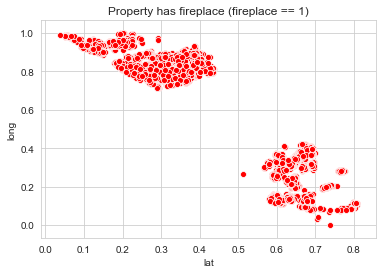

In [284]:
sns.scatterplot(x='lat', y='long', data=train[train.fireplace == 1], color='red')
plt.title('Property has fireplace (fireplace == 1)')


Text(0.5, 1.0, 'Property has fireplace (fireplace == 0)')

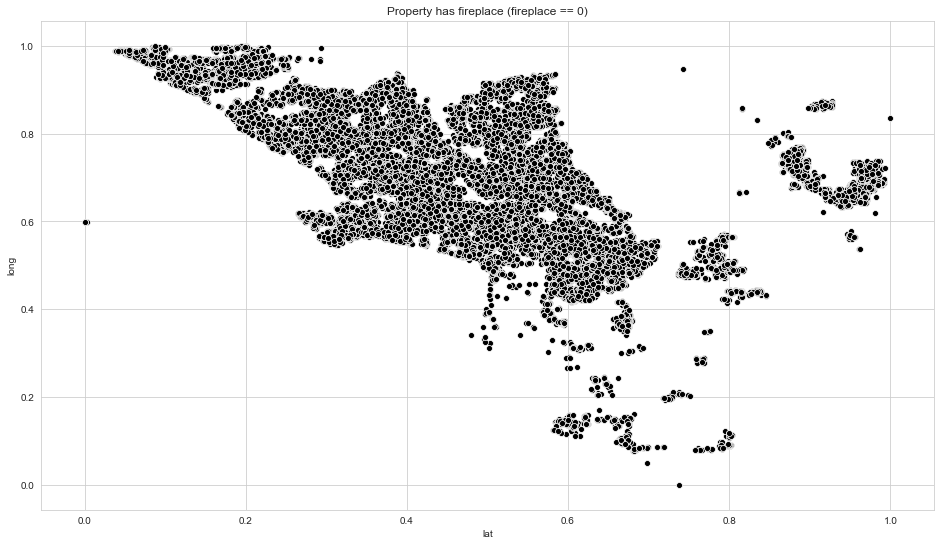

In [285]:
plt.figure(figsize=(16,9))
sns.scatterplot(x='lat', y='long', data=train[train.fireplace == 0], color='black')
plt.title('Property has fireplace (fireplace == 0)')


Text(0.5, 1.0, 'Other neigborhoods')

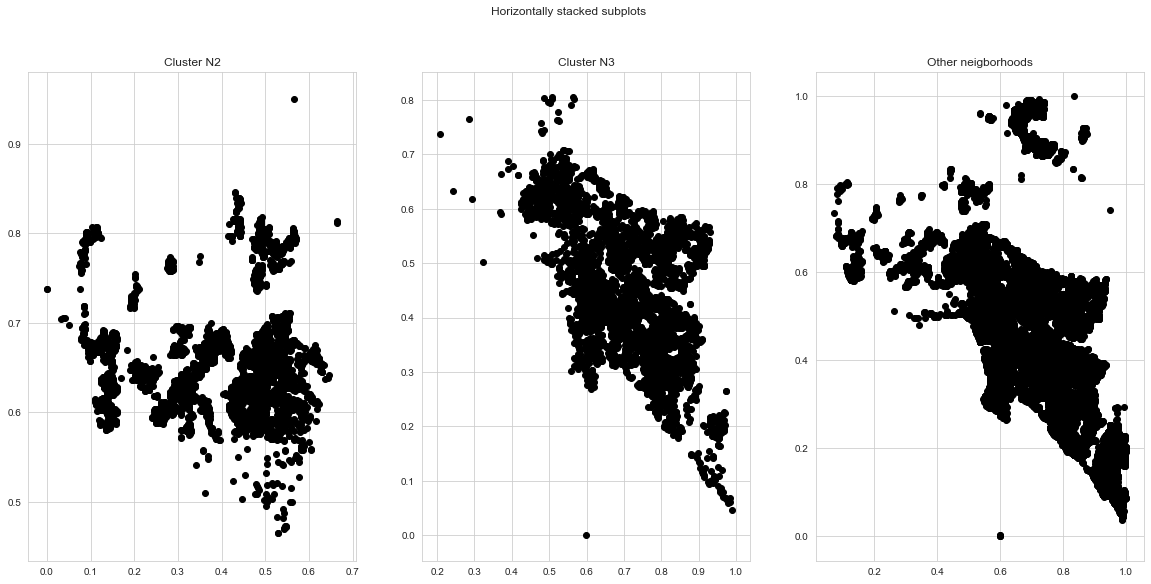

In [286]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,9))
fig.suptitle('Horizontally stacked subplots')
ax1.scatter(x=train[train.n2==1].long, y=train[train.n2==1].lat, color = 'black')
ax1.set_title('Cluster N2')
ax2.scatter(x=train[train.n3==1].long, y=train[train.n3==1].lat, color = 'black')
ax2.set_title('Cluster N3')
ax3.scatter(x=train[(train.n2 == 0) & (train.n3 == 0)].long, y=train[(train.n2 == 0) & (train.n3 == 0)].lat, color = 'black')
ax3.set_title('Other neigborhoods')


***Create datasets***

In [288]:
# Create a dataset dictionary:
# data1 includes our data without scaling or encoding and only uses these features: 'sqft', 'lotsqft', 'tax', 'age'
# data includes all features with scaling and encoding
# data2 eliminates features that did not pass our data validation test
# data3 is data with all cluster features added
# data3a is data3 but only amenities clusters
# data3n is data3 but only neighborhood clusters
# data4 is data3 but with feature validation
# data4a is data4 but only amenities clusters
# data4n is data4 but only neighborhood clusters
# data5 is data2 without several features deemed to have little bearing on logerror
rem_neighbor = [c for c in X4_train.columns if c[0] == 'n']
rem_amenity = [c for c in X4_train.columns if c[0] == 'a']
insig = ['age', 'la', 'lotsqft', 'orange', 'pool', 'sqft', 'tax']
common_cols = list(set(test2.columns).intersection(X2_train.columns))
test2 = test2[common_cols + ['logerror']]
X3_train = X3_train.drop(columns='logerror')
X_train = X_train.drop(columns='logerror')
X3a_train = X3_train.drop(columns=neighbor_feats)
X3n_train = X3_train.drop(columns=amenities_feats)
test3a = test3.drop(columns=neighbor_feats)
test3n = test3.drop(columns=amenities_feats)
X4a_train = X4_train.drop(columns=rem_neighbor)
X4n_train = X4_train.drop(columns=rem_amenity)
test4a = test4.drop(columns=rem_neighbor)
test4n = test4.drop(columns=rem_amenity)
X5_train = X2_train.drop(columns=insig)
test5 = test2.drop(columns=insig)
datasets = {
    'data1': {'x': X1_train, 'y': y1_train, 'test': test1},
    'data': {'x': X_train, 'y': y_train, 'test': test},
    'data2': {'x': X2_train, 'y': y_train, 'test': test2},
    'data3': {'x': X3_train, 'y': y_train, 'test': test3},
    'data3a': {'x': X3a_train, 'y': y_train, 'test': test3a},
    'data3n': {'x': X3n_train, 'y': y_train, 'test': test3n},
    'data4': {'x': X4_train, 'y': y_train, 'test': test4},
    'data4a': {'x': X4a_train, 'y': y_train, 'test': test4a},
    'data4n': {'x': X4n_train, 'y': y_train, 'test': test4n},
    'data5': {'x': X5_train, 'y': y_train, 'test': test5}}


In [289]:
models1 = many_models(datasets['data1'])

In [290]:
scores1 = evaluate_dict(models1)

In [291]:
scores1

{'lm2': 0.013991323035236005,
 'lm3': 0.014330501307568794,
 'lm4': 0.013996796065838753,
 'lm5': 5.925166825999414e+29,
 'lm6': 522632.48190474964,
 'lm7': 57016230.31981191,
 'lm8': 3.198621155696828e+30,
 'lm9': 3.198621155696828e+30}

In [292]:
models = many_models(datasets['data'])
scores = evaluate_dict(models)
scores

{'lm2': 0.01395096364831487,
 'lm3': 0.014074299770647275,
 'lm4': 0.01394400094872485,
 'lm5': 0.013949982047604267,
 'lm6': 0.014017685746378654,
 'lm7': 0.0139855619665364,
 'lm8': 0.014923776386488011,
 'lm9': 0.014923776386488011}

In [293]:
models2 = many_models(datasets['data2'])
scores2 = evaluate_dict(models2)
scores2

{'lm2': 0.013948182140188206,
 'lm3': 0.014056795779268978,
 'lm4': 0.01394818215529265,
 'lm5': 0.013954457335599359,
 'lm6': 0.014020174833775729,
 'lm7': 0.01399189578244128,
 'lm8': 0.014915609880322957,
 'lm9': 0.014915609880322957}

In [294]:
models3 = many_models(datasets['data3'])
scores3 = evaluate_dict(models3)
scores3

{'lm2': 0.013959565022116208,
 'lm3': 0.01401471534342712,
 'lm4': 0.013948393439526119,
 'lm5': 0.013952260593586273,
 'lm6': 0.01400786063382493,
 'lm7': 0.013988398293710397,
 'lm8': 0.015149942698189716,
 'lm9': 0.015149942698189716}

In [295]:
models4 = many_models(datasets['data4'])
scores4 = evaluate_dict(models4)
scores4

{'lm2': 0.013954404252104867,
 'lm3': 0.01404248804772541,
 'lm4': 0.013954404254701043,
 'lm5': 0.013956182637934083,
 'lm6': 0.01400980043099725,
 'lm7': 0.013979017952651987,
 'lm8': 0.015162239443301778,
 'lm9': 0.015162239443301778}

In [296]:
models5 = many_models(datasets['data5'])
scores5 = evaluate_dict(models5)
scores5

{'lm2': 0.013956316679983186,
 'lm3': 0.014029538501051651,
 'lm4': 0.013956316690737257,
 'lm5': 0.013956677150718726,
 'lm6': 0.0140176946729893,
 'lm7': 0.013964534652098522,
 'lm8': 0.015102745970143648,
 'lm9': 0.015102745970143648}

lm2 is a plain LinearRegression

lm3 is a LinearSVR (support vector regressor) using the epsilon-insensitive loss function

lm4 is a LinearSVR (support vector regressor) using the squared epsilon-insensitive loss function

lm5 is an SGDRegressor (stochastic gradient descent) using the squared loss function

lm6 is an SGDRegressor (stochastic gradient descent) using the Huber loss function

lm7 is an SGDRegressor (stochastic gradient descent) using the squared epsilon-insensitive loss function

lm8 is a LassoCV regression

We tried using DecisionTreeRegressors as well, but they took very long to make. Further, they were less accurate than our linear models and seemed to always overfit regardless of how low I set the max_depth parameter

In [302]:
from model import evaluate
x = models5['lm2']['data']['test'][models5['lm2']['data']['x'].columns]
y = models5['lm2']['data']['test']['logerror']
evaluate(models5['lm2']['obj'], x, y)

0.016436906266662502

We got an RMSE of .01644 on our test data.